# TORCphysics Example 2.: Gene Circuit Simulation, Analysis and Estimations

## Overview
This notebook revisits the system composed of two genes from Example 1 and demonstrates how to further extend the analysis of gene circuits.

We will:
- Run multiple independent simulations of the system to obtain a population of results.
- Instead of generating output CSV files, we will keep the results stored in memory for further analysis.
- Perform statistical analysis on the simulations, outputting estimations of interest.

## Gene Circuit Structure
We have a system composed by two genes in a tandem orientation in the form of:
X________-------left------>________------right------>________X

where X's indicate the surrounding barriers and -----> a gene pointing to the right.
We refer to the genes as 'left' and 'right'.



In [12]:
# Load modules
# ------------------------------------------------------------------------------------------------------------------------
from TORCphysics import Circuit
from TORCphysics import analysis as an
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# Simulation Conditions
# ------------------------------------------------------------------------------------------------------------------------
#Let's use sites_3.csv and environment_4.csv to produce multiple light and fast simulations.
# Using these inputs, will run the system with multistage supercoiling-dependent transcription initiation
# (closed -> open complex -> elongation) and  RNAP elongation (stalling included) with the continuum effect of topoisomerases acting
# on all topological domains.
# Simulation conditions
circuit_filename = 'circuit.csv'
sites_filename = 'sites_3.csv'  # This one contains transcription initiation modulated by supercoiling
enzymes_filename = None  # This input is optional, no enzymes_file means that nothing is bound
environment_filename = 'environment_4.csv'  # This one contains uniform RNAPs and topoisomerases acting continously
output_prefix = 'output2'
frames = 3600
series = True
continuation = False
dt = 1

n_sims = 20 # We will run n_sims simulations for this example.

gene_names = ['left', 'right']

colors = {'left': 'yellow', 'right': 'blue', 'circuit': 'black'}  # circuit refers to global quantities, e.g. global supercoiling



In [14]:
# Run multiple simulations
# ------------------------------------------------------------------------------------------------------------------------

# Let's prepare lists to store the dataframes of each simulation.
enzymes_df_list =[]
sites_df_list = []
environment_df_list = []
# Run parallel simulation and let's store the dataframes on different lists
for n in range(n_sims):
    # Initialize circuit with the initial conditions
    my_circuit = Circuit(circuit_filename, sites_filename, enzymes_filename, environment_filename,
                         output_prefix, frames, series, continuation, dt)
    my_circuit.name = my_circuit.name + '_' + str(n) # We can change the name of the circuit

    # Run simulations but storing dataframes on memory then adding them to the lists.
    enzymes_df, sites_df, environment_df = my_circuit.run_return_dfs() # Function run_return_dfs() returns the dataframes with the results of the simulation (it does not write CSV files).

    # Append dataframes to the lists.
    enzymes_df_list.append(enzymes_df)
    sites_df_list.append(sites_df)
    environment_df_list.append(environment_df)


Text(0.5, 0, 'Time (s)')

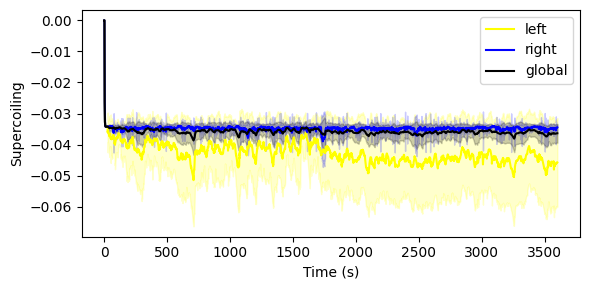

In [15]:
# Let's plot average supercoiling
names = ['left', 'right', 'circuit']
time = np.arange(0, (frames+1) * dt, dt)
fig, axs = plt.subplots(1, figsize=(6,3), tight_layout=True)
for name in names:
    superhelical = []
    for n in range(n_sims):
        sites_df = sites_df_list[n]
        if name == 'circuit':  # If it's circuit we filter by type to get the global supercoiling. But if it is a site name we filter by site.
            mask = sites_df['type'] == name
            mylabel = 'global'
        else:
            mask = sites_df['name'] == name
            mylabel=name
        sigma = sites_df[mask]['superhelical'].to_numpy()
        superhelical.append(sigma)
    y = np.mean(superhelical, axis=0)
    ys = np.std(superhelical, axis=0)
    axs.plot(time, y, label=mylabel, color=colors[name])
    axs.fill_between(time, y-ys, y+ys, alpha=0.2, color=colors[name])
axs.legend()
axs.set_ylabel('Supercoiling')
axs.set_xlabel('Time (s)')

The averaged global supercoiling shows that it is consistent through all simulations. Hownever, local supercoiling on the left and right gene has more variation as transcription events occur at different times through simulations.

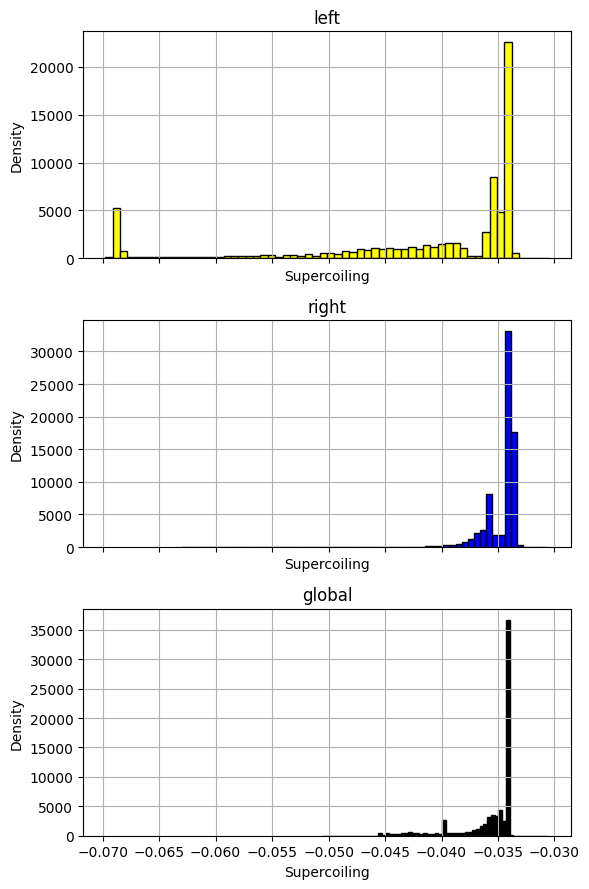

In [5]:
# Let's distribution of supercoils rather than averages.
names = ['left', 'right', 'circuit']
fig, axs = plt.subplots(3, figsize=(6,9), tight_layout=True, sharex=True)
for i, name in enumerate(names):
    ax = axs[i]
    superhelical = []
    for n in range(n_sims):
        sites_df = sites_df_list[n]
        if name == 'circuit':  # If it's circuit we filter by type to get the global supercoiling. But if it is a site name we filter by site.
            mask = sites_df['type'] == name
            mylabel = 'global'
        else:
            mask = sites_df['name'] == name
            mylabel = name
        sigma = sites_df[mask]['superhelical'].to_numpy()
        superhelical.append(sigma)
    ax.set_title(mylabel)
    flat_superhelical = np.concatenate(superhelical)
    # But let's filter unlikely cases
    filtered = flat_superhelical[(flat_superhelical >= -.07) & (flat_superhelical <= -0.03)]
    # Plot as a histogram
    ax.hist(filtered, bins=60, edgecolor='black', color=colors[name])
    ax.set_ylabel(r'Density')
    ax.set_xlabel('Supercoiling')
    ax.grid(True)




The distribution supercoils show a really high peak around -0.035 which is mainly due to the activity of RNAPs and the continuum effect of topoisomerases. These peaks on the left and right genes (promoters) are consistent with the global supercoiling, however, there is a considerable portion of supercoils around -0.070 for the left gene. This is likely due to its proximity to the upstream barrier, where during initiation, a high portion of negative supercoils accumulate.

Does the system converge to steady state?
Does the average transcription rates correspond to the sites_3.csv rates?


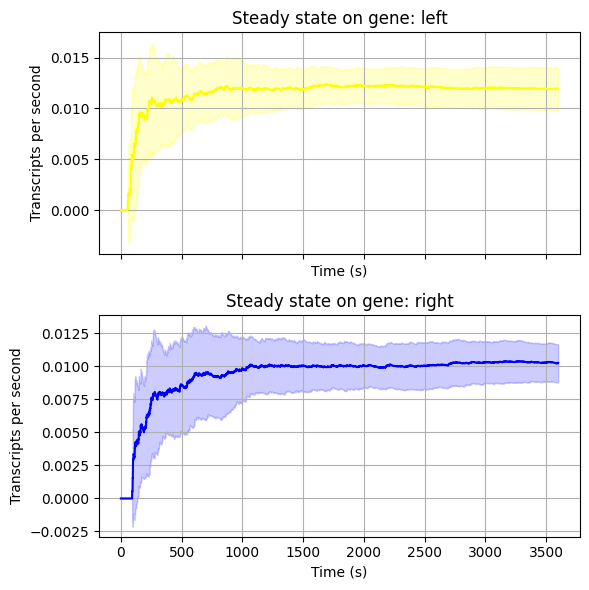

In [6]:
# Steady state
names = gene_names
time = np.where(time == 0, 1e-10, time) # Let's make time 0 really small to avoid issues with division by zero.
fig, axs = plt.subplots(2, figsize=(6,6), tight_layout=True, sharex=True)
for i, name in enumerate(names):
    ax = axs[i]
    ax.set_title('Steady state on gene: '+name)
    transcripts = []
    for n in range(n_sims):
        environment_df = environment_df_list[n]
        mask = environment_df['name'] == name
        my_transcript = np.zeros_like(time)
        ts = environment_df[mask]['concentration'].to_numpy()
        ndif = len(my_transcript) - len(ts)
        my_transcript[ndif:] = ts
        transcripts.append(my_transcript)

    y = np.mean(transcripts, axis=0)/time
    ys = np.std(transcripts, axis=0)/time
    ax.plot(time, y, color=colors[name])
    ax.fill_between(time, y-ys, y+ys, alpha=0.2, color=colors[name])
    ax.grid(True)
    ax.set_ylabel('Transcripts per second')
    ax.set_xlabel('Time (s)')

print('Does the system converge to steady state?')
print('Does the average transcription rates correspond to the sites_3.csv rates?')


Text(0.5, 0, 'Time lag (s)')

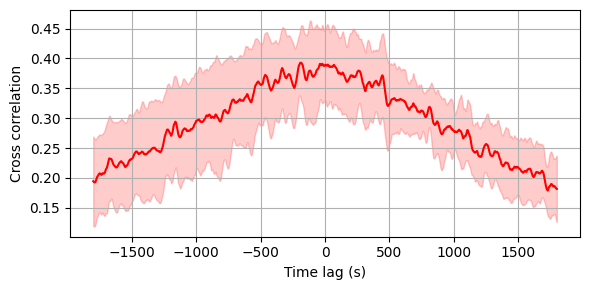

In [18]:
# Cross correlation
names = gene_names
time = np.where(time == 0, 1e-10, time) # Let's make time 0 really small to avoid issues with division by zero.
fig, axs = plt.subplots(1, figsize=(6,3), tight_layout=True, sharex=True)
crosscorrelations = []
for n in range(n_sims):
    enzymes_df = enzymes_df_list[n]
    sites_df = sites_df_list[n]
    signals, nn = an.build_signal_by_type(sites_df, 'gene')
    signals = an.build_elongation_signal_stages(enzymes_df, gene_names)
    crossmatrix, lag =  an.cross_correlation_hmatrix(signals, dt)
    crosscorrelations.append(crossmatrix[1, 0, :])
y = np.mean(crosscorrelations, axis=0)
ys = np.std(crosscorrelations, axis=0)
axs.plot(lag, y, color='red')
axs.fill_between(lag, y-ys, y+ys, alpha=0.2, color='red')
axs.grid(True)
axs.set_ylabel('Cross correlation')
axs.set_xlabel('Time lag (s)')
#axs.set_xlim(-200, 200)


## Takeaway Notes:
- You can run multiple simulations and store its output dataframes in memory without the need of producing csv files.
- To analyse circuits, it is recommended to run multiple simulations and analyset them collectively.